<h2>
Stock Market Cash Trigger</br>
by Ian Kaplan</br>
</h2>

<p>
This notebook explores a stock market timing strategy that is described in David
Alan Carter's book <i>Stock Market Cash Trigger</i> (available as an Amazon Kindle book).
</p>
<p>
This Python notebook is available in the GitHub repository
<a href="https://github.com/IanLKaplan/cash_trigger">
https://github.com/IanLKaplan/cash_trigger</a>
</p>
<p>
In the <i>Stock Market Cash Trigger</i> the 200-day moving average for the S&P 500
(the ETF SPY) close prices are compared with the current close SPY price. When the current
close price for SPY trends below the 200-day moving average, this is a
signal to move out of equity instruments into bond instruments. An ETF rotation strategy
is used to select a bond asset
(see the notebook <a href="https://github.com/IanLKaplan/twelve_percent/blob/master/twelve_percent.ipynb">
ETF Rotation</a>).
</p>
<p>
The book <i>Stock Market Cash Trigger</i> presents evidence that this strategy can perform better
than a "buy and hold" strategy.  Figure 32, from the book, is shown below. This table shows
a "buy and hold" investment in Microsof stock (MSFT) vs. an invesment that uses the <i>Cash Trigger</i>
strategy.
</p>

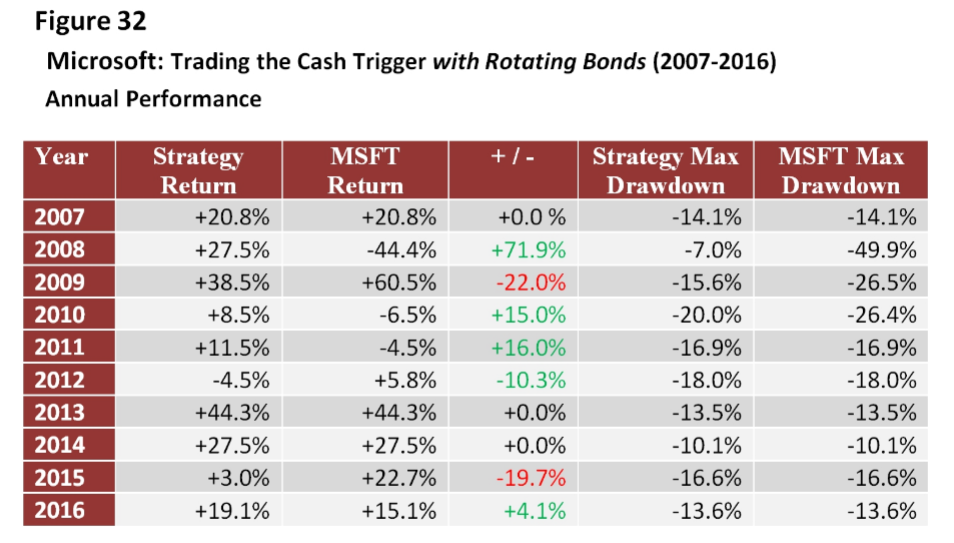

In [1]:
from enum import Enum

from IPython.core.display import Image
from dateutil.relativedelta import relativedelta
from numpy import sqrt

Image(filename='images/msft_strategy.png')

<p>
Note that the <i>Cash Trigger</i> results shown in the book's Figure 32 are for an investment
in 2007 which avoids the 2009-2009 market downturn. As we shall see, investments that start in this
period do much better than investments that start in later years. This is due to continuous
compounding of the strategy profits from the 2008-2009 downturn.
</p>
<p>
This notebook attempts to reproduce the results from <i>Stock Market Cash Trigger</i> and
explore these results in various time frames.  Extensions of the <i>Cash Trigger</i> strategy
are also explored.
</p>
<p>
Technical analysis is used by some stock market traders to attempt to determine
which stocks should be traded and when they should be bought and sold.  Technical
analysis has been compared to voodoo magic because many of the trading signals used
in technical analysis do not have strong quantitative descriptions or emperical evidence for
their strength in discovering profitable trades. Often trading based on technical analysis
can only be done by a person because the
rules are not clearly defined enough to implement in computer software.
</p>
<p>
The moving average signals discussed in <i>Stock Market Cash Trigger</i> could be
considered a technical analysis strategy. Unlike some technical analysis signals, the
<i>Cash Trigger</i> signal has a relatively clear definition. The author, David Alan Carter,
discusses why be believes the 200-day moving average is a good trading signal.  He
also compares the 200-day moving average to some other moving average trading
signals. Rather than reproduce this discussion
here, I recommend that you read the <i>Stock Market Cash Trigger</i>.
</p>
<p>
In the book, the definition of "trending below" the SPY 200-day moving average is when,
on the last day of a month, the close price of SPY is below the 200-day average.
</p>
<p>
The description in the <i>Stock Market Cash Trigger</i> is designed to be used
by human traders. A human trader looking at stock market plots can often see
when the 200-day moving average for SPY is trending below the current the
SPY close price. A computer algorithm requires a more exact definition.
</p>
<p>
In this notebook the 200-day moving average and the current price are rounded
to zero decimal places and compared. If the current value SPY close price is less
than or equal to the 200-day average this is a signal to move out of equities
and into bonds.
</p>
<p>
If the cash trigger points to moving out of equity instruments, a
bond ETF is selected. In the <i>Stock Market Cash Trigger</i> this one
of three bond ETFS: JNK, TLT or MUB.  In this notebook the SHY ETF is added
to the bond mix.  SHY is close to being a proxy for cash and should have
a positive return when the other bond funds are negative.
</p>
<p>
The bond ETF that is chosen for the next month is the bond ETF with the
highest three month return (this is the ETF rotation technique that is
explored at length in the notebook
<a href="https://github.com/IanLKaplan/twelve_percent/blob/master/twelve_percent.ipynb"><i>The 12% Solution</i></a>)
</p>
<p>
The ETF instruments in the book <i>Stock Market Cash Trigger</i> are:
</p>
<h3>
S&P 500 ETF
</h3>
<ul>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>

<h3>
Bond ETFs
</h3>
<ul>
<li>
<p>
TLT: iShares 20+ Year Treasury Bond ETF
</p>
<p>
TLT tracks a market-weighted index of debt issued by the US Treasury
with remaining maturities of 20 years or more.
</p>
<p>
Inception date: 7/22/2002
</p>
</li>
<li>
<p>
JNK: SPDR Bloomberg High Yield Bond ETF
</p>
<p>
JNK tracks a market-weighted index of highly liquid, high-yield, US
dollar-denominated corporate bonds.
</p>
<p>
Inception date: 11/28/2007
</p>
</li>
<li>
<p>
MUB: iShares National Muni Bond ETF
</p>
<p>
MUB tracks a market-weighted index of investment-grade debt issued by state
and local governments and agencies. Interest is exempt from US income tax
and from AMT.
</p>
<p>
Inception date: 09/09/2007
</p>
</li>
</ul>
<h3>
Cash Proxy
</h3>
<ul>
<li>
<p>
SHY: iShares 10-20 Year Treasury Bond ETF
</p>
<p>
SHY tracks a market weighted index of debt issued by the US Treasury
with 1-3 years remaining to maturity. Treasury STRIPS are excluded.
</p>
<p>
Inception date: 07/22/2002
</p>
</li>
</ul>
<h3>
Time Period
</h3>
<p>
A start date of March 3, 2008 is used to allow a sufficient lookback period
for the JNK ETF.
</p>
<p>
Many examples in the book <i>Stock Market Cash Trigger</i> run from
2007 through 2016. As noted above, the ETF rotation for bonds needs to start in
2008 so that there is sufficient history.
</p>
<h3>
Close Prices vs Adjusted Close Prices
</h3>
<p>
The SPY time series uses SPY close prices, rather than adjusted close prices
that factor in dividend payments. Although SPY does pay a small dividend
(about 1.3%), this can be ignored.
</p>

In [2]:
from datetime import datetime, timedelta
from tabulate import tabulate
from typing import List, Tuple
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.indexes.datetimes import DatetimeIndex
import numpy as np
from pathlib import Path
import tempfile

# QuantStrats was written by Ran Aroussi. See https://aroussi.com/
# See https://pypi.org/project/QuantStats/
# # https://github.com/ranaroussi/quantstats
# pip install QuantStats
import quantstats as qs

plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = 'raise'


def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        if type(symbols) == str:
            t = list()
            t.append(symbols)
            symbols = t
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    return close_data


trading_days = 252
trading_quarter = trading_days // 4

window_size = 200

data_source = 'yahoo'

start_date_str = '2008-03-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
# The "current date"
end_date: datetime = datetime.today() - timedelta(days=1)


def convert_date(some_date):
    if type(some_date) == str:
        some_date = datetime.fromisoformat(some_date)
    elif type(some_date) == np.datetime64:
        ts = (some_date - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
        some_date = datetime.utcfromtimestamp(ts)
    return some_date


def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    search_date = convert_date(search_date)
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = convert_date(date_index[i])
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    else:
        index = i
    return index


class RiskState(Enum):
    RISK_OFF = 0
    RISK_ON = 1


class SpyData:
    spy_close_file = 'spy_close'
    spy_etf = "SPY"
    spy_close: pd.DataFrame
    date_index: DatetimeIndex

    def __init__(self, start_date: datetime, end_date: datetime) -> object:
        """
        start_date: the start of the period for the SPY data.  One year
        before this date will be fetched to allow for a moving average
        from start_date
        end_date: the end of the period for the SPY data.
        """
        spy_start: datetime = start_date - timedelta(days=365)
        self.spy_close = get_market_data(file_name=self.spy_close_file,
                                         data_col='Close',
                                         symbols=self.spy_etf,
                                         data_source=data_source,
                                         start_date=spy_start,
                                         end_date=end_date)
        self.date_index = self.spy_close.index

    def close_data(self, start_date: datetime, end_date: datetime) -> pd.DataFrame:
        """
        Return a section of SPY close prices from start_date to end_date
        """
        start_ix = findDateIndex(date_index=self.date_index, search_date=start_date)
        end_ix = findDateIndex(date_index=self.date_index, search_date=end_date)
        spy_close_df = pd.DataFrame()
        assert start_ix >= 0 and end_ix >= 0
        spy_close_df = self.spy_close[:][start_ix:end_ix+1].copy()
        return spy_close_df

    def avg(self, day: datetime, window: int = window_size) -> float:
        """
        :param day: the end date for the window
        :param window: the size of the window extending back from day
        :return: the average for the SPY close prices in the window
        """
        _average: float = -1.0
        end_ix = findDateIndex(date_index=self.date_index, search_date=day)
        start_ix = end_ix - (window -1)
        assert start_ix >= 0 and end_ix >= 0
        _average = self.spy_close.values[start_ix:end_ix+1].mean()
        return _average


    def moving_avg(self, start_date: datetime, end_date: datetime, window: int = window_size) -> pd.DataFrame:
        """
        Compute a moving average series
        :param start_date: the start date for the moving average series
        :param end_date: the end date for the moving average series
        :param window: the window size that extends, initially, back from start_date
        :return: a moving average series as a DataFrame. The date index will be the same
                 as the SPY time DataFrame between start_date and end_date
        """
        start_ix = findDateIndex(date_index=self.date_index, search_date=start_date)
        end_ix = findDateIndex(date_index=self.date_index, search_date=end_date)
        assert start_ix >= 0 and end_ix >= 0
        num_vals = (end_ix - start_ix) + 1
        moving_avg_a = np.zeros(num_vals)
        avg_index = self.date_index[start_ix:end_ix + 1]
        for i in range(0, num_vals):
            date_i = avg_index[i]
            mv_avg_i = self.avg(date_i)
            moving_avg_a[i] = mv_avg_i
        avg_df = pd.DataFrame(moving_avg_a)
        avg_df.index = avg_index
        avg_df.columns = [f'{self.spy_etf} {window_size}-day avg']
        return avg_df


    def risk_state(self, day: datetime) -> RiskState:
        spy_avg = self.avg(day)
        day_ix = findDateIndex(date_index=self.date_index, search_date=day)
        spy_val = float(self.spy_close.values[day_ix:day_ix+1])
        # only use full dollar price changes
        spy_avg = round(spy_avg, 0)
        spy_val = round(spy_val, 0)
        state: RiskState = RiskState.RISK_ON if spy_val > spy_avg else RiskState.RISK_OFF
        return state


spy_data = SpyData(start_date, end_date)

spy_close = spy_data.close_data(start_date, end_date)
spy_moving_avg = spy_data.moving_avg(start_date, end_date)
plot_df = pd.concat([spy_close, spy_moving_avg], axis=1)

<h3>
200-day SPY moving average
</h3>
<p>
The plot below shows the 200-day SPY moving average, plotted with the SPY close
prices.
</p>
<p>
The strategy moves out of equities into bonds when the SPY close price is below
the 200-day moving average.  Looking at this plot you can see that it looks like the
market downturns are all below the 200-day moving average.
</p>
<p>
Except for the market downturns that have sufficient duration for the strategy to catch them,
the SPY close price is above the 200-day moving average.
</p>

<AxesSubplot:title={'center':'SPY and 200-day average: 03/03/2008 - 05/19/2022'}, xlabel='Date'>

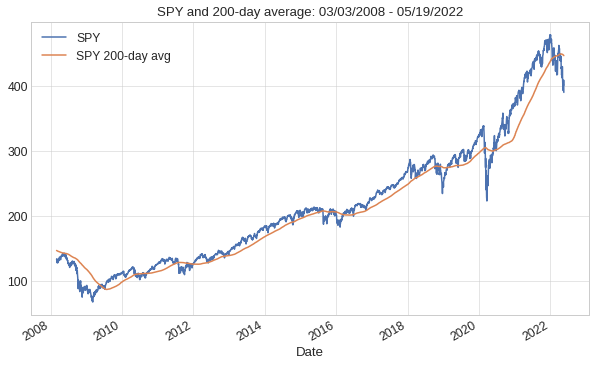

In [3]:
plot_df.plot(grid=True, title=f'SPY and 200-day average: {start_date.strftime("%m/%d/%Y")} - {end_date.strftime("%m/%d/%Y")}', figsize=(10,6))

<h2>
Cash Trigger Strategy
</h2>
<p>
The <a href="https://www.trendlineprofits.com/">trendlineprofits.com</a> website
is available to purchasers of the <i>Stock Market Cash Trigger</i> book.  The
website has a concise description of the cash trigger strategy that is quoted
below.
</p>
<blockquote>
<p>
Once a month, preferably on the last trading day of the month, the strategy
first determines whether the broader U.S. stock market is in a risk-on or risk-off
regime using the 200-day simple moving average of SPY. This is our Regime-O-Meter.
If the price line for SPY is trending above its 200-day simple moving average,
it's risk-on -- and off to the races. Translation: You buy and hold the risk
asset(s) of your choice.
</p>
<p>
On the other hand, if the price line of SPY is trending below the 200-day MA,
the broader market is in a risk-off environment. In that case, we buy and hold
one of four flight-to-safety bond funds as determined by a relative strength
test using a 3-month lookback.
</p>
<p>
Rinse and repeat the next month.
</p>
<p>
So, at any given time our Cash Trigger portfolio holds either the risk assets
of your choice, or a single flight-to-safety bond fund.
</p>
</blockquote>

<h3>
First day vs. last day of the month
</h3>
<p>
Software from <a href="https://github.com/IanLKaplan/twelve_percent/blob/master/twelve_percent.ipynb"><i>The 12% Solution</i></a>
is reused in this notebook. <i>The 12% Solution</i> strategy trades at the start of
every month, instead of the last trading day of the month.
</p>
<p>
In the Q&A section of <i>Stock Market Cash Trigger</i> the author writes that there
is, at most, a small advantage in trading at the end of the month.
</p>
<p>
In keeping with <i>The 12% Solution</i> strategy trading in the backtests in this notebook
is at the start of the month.
</p>

In [4]:
def chooseAssetName(start: int, end: int, asset_set: pd.DataFrame) -> str:
    '''
    Choose an ETF asset in a particular range of close price values.
    The function returns the name of the asset with the highest returning
    asset in the period.
    '''
    asset_columns = asset_set.columns
    asset_name = asset_columns[0]
    if len(asset_columns) > 1:
        ret_list = []
        start_date = asset_set.index[start]
        end_date = asset_set.index[end]
        for asset in asset_set.columns:
            ts = asset_set[asset][start:end+1]
            start_val = ts[0]
            end_val = ts[-1]
            r = (end_val/start_val) - 1
            ret_list.append(r)
        ret_df = pd.DataFrame(ret_list).transpose()
        ret_df.columns = asset_set.columns
        ret_df = round(ret_df, 3)
        column = ret_df.idxmax(axis=1)[0]
        asset_name = column
    return asset_name


def find_month_periods(start_date: datetime, end_date:datetime, data: pd.DataFrame) -> pd.DataFrame:
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    date_index = data.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    start_l = list()
    end_l = list()
    cur_month = start_date.month
    start_l.append(start_ix)
    i = 0
    for i in range(start_ix, end_ix+1):
        date_i = convert_date(date_index[i])
        if date_i.month != cur_month:
            end_l.append(i-1)
            start_l.append(i)
            cur_month = date_i.month
    end_l.append(i)
    # if there is not a full month period, remove the last period
    if end_l[-1] - start_l[-1] < 18:
        end_l.pop()
        start_l.pop()
    start_df = pd.DataFrame(start_l)
    end_df = pd.DataFrame(end_l)
    start_date_df = pd.DataFrame(date_index[start_l])
    end_date_df = pd.DataFrame(date_index[end_l])
    periods_df = pd.concat([start_df, start_date_df, end_df, end_date_df], axis=1)
    periods_df.columns = ['start_ix', 'start_date', 'end_ix', 'end_date']
    return periods_df


def find_year_periods(data: pd.DataFrame) -> pd.DataFrame:
    date_index = data.index
    start_l = list()
    end_l = list()
    year_l = list()
    start_l.append(0)
    current_year = convert_date(date_index[0]).year
    year_l.append(current_year)
    for i in range(1, len(date_index)):
        date_i = convert_date(date_index[i])
        year_i = date_i.year
        if (year_i > current_year):
            end_l.append(i-1)
            start_l.append(i)
            year_l.append(year_i)
            current_year = year_i
    end_l.append(i)
    periods_df = pd.DataFrame(list(zip(start_l, end_l, year_l)), columns=['start_ix', 'end_ix', 'year'])
    return periods_df


def simple_return(time_series: np.array, period: int = 1) -> List :
    return list(((time_series[i]/time_series[i-period]) - 1.0 for i in range(period, len(time_series), period)))


def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    r_df: pd.DataFrame = pd.DataFrame()
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df


def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros( return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = return_df.values
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i-1] + port_a[i-1] * return_a[i-1]
    return port_a


def portfolio_return(holdings: float,
                     risk_asset: pd.DataFrame,
                     bond_asset: pd.DataFrame,
                     spy_data: SpyData,
                     start_date: datetime,
                     end_date: datetime) -> Tuple[pd.DataFrame, pd.DataFrame]:
    portfolio_a = np.zeros(0)
    portfolio_val = holdings
    name_l: List = []
    date_l: List = []
    month_periods = find_month_periods(start_date, end_date, risk_asset)
    for index, period in month_periods.iterrows():
        start_ix = period['start_ix']
        end_ix = period['end_ix']
        period_start_date: datetime = convert_date(period['start_date'])
        r_df = pd.DataFrame()
        asset_name = ''
        if spy_data.risk_state(period_start_date) == RiskState.RISK_ON:
            asset_name: str = chooseAssetName(start_ix, end_ix, risk_asset)
            risk_close_prices = pd.DataFrame(risk_asset[asset_name][start_ix:end_ix+1])
            r_df = return_df(risk_close_prices)
        else: # RISK_OFF - bonds
            asset_name: str = chooseAssetName(start_ix, end_ix, bond_asset)
            bond_close_prices = pd.DataFrame(bond_asset[asset_name][start_ix:end_ix+1])
            r_df = return_df(bond_close_prices)
        name_l.append(asset_name)
        date_l.append(period['start_date'])
        port_month_a = apply_return(portfolio_val, r_df)
        portfolio_val = port_month_a[-1]
        portfolio_a = np.append(portfolio_a, port_month_a)
    portfolio_df = pd.DataFrame(portfolio_a)
    portfolio_df.columns = ['portfolio']
    num_rows = month_periods.shape[0]
    first_row = month_periods[:][0:1]
    last_row = month_periods[:][num_rows - 1:num_rows]
    start_ix = first_row['start_ix'].values[0]
    end_ix = last_row['end_ix'].values[0]
    date_index = risk_asset.index
    portfolio_index = date_index[start_ix:end_ix + 1]
    portfolio_df.index = portfolio_index
    assets_df = pd.DataFrame(name_l)
    assets_df.columns = ['asset']
    assets_df.index = date_l
    return portfolio_df, assets_df

<h3>
Calculating Portfolio Values
</h3>
<p>
The portfolio values in <i>The 12% Solution</i> notebook are significantly different
from the values shown on the <i>trendlineprofits.com</i> website.  In backtesting <i>The
12% Solution</i> strategy and the <i>Cash Trigger</i> strategy, the author, David Allen
Carter, uses software on ETFReplay.com to calculate portfolio values. There may be an
error in the way ETFReplay.com calculates portfolio values.
</p>
<p>
The portfolio values in this notebook for the <i>Cash Trigger</i> also differ
somewhat from those on the website, although the difference is not as dramatic as it
is for <i>The 12% Solution</i>.
</p>
<p>
This section discusses how portfolio values are calculated in this notebook. This
explains some, but not all, of the differences between the portfolio values in this
notebook and those reported on <i>Trendlineprofits.com</i>.
</p>
<p>
In the <i>Stock Market Cash Trigger</i> strategy in June of 2009 the portfolio might be
invested in a risk asset SPY. In July the portfolio might be invested in a bond
asset TLT.
</p>
<p>
On the first trading day of June, the current portfolio balance is used to purchase SPY.
SPY is held until the end of June, when it is sold.  In July the portfolio balance is used
to purchase TLT on the first trading day. TLT is held through the end of July.
</p>
<p>
This mirrors how someone would actually trade the <i>Stock Market Cash Trigger</i> strategy.
This differs from holding a single asset, like SPY, over the entire period.
</p>
<p>
To see why this is the case, lets pretend that all months consist of for trading days.  For this
example the months will be named a and b.
</p>

\$ a_1 \space a_2 \space a_3 \space a_4 \space b_1 \space b_2 \space b_3 \space b_4 $

<p>
If we have a single asset that is held over the two month period, the first seven returns
would be
</p>

\$ r_i = \frac{p_i}{p_{i-1}} - 1 $

\$ r_1 = \frac{a_2}{a_1} - 1 $

\$ r_2 = \frac{a_3}{a_2} - 1 $

\$ r_3 = \frac{a_4}{a_3} - 1 $

\$ r_4 = \frac{b_1}{a_4} - 1 $

\$ ... $

\$ r_7 = \frac{b_4}{b_3} - 1 $

<p>
Note that the return r<sub>4</sub> is calculated across a month boundary.
</p>

\$ R = [ r_1, ... r_7  ] $

\$ V = [ h, 0, 0, 0, 0, 0, 0, 0 ] $

<p>
Where <i>h</i> is the portfolio start value and V is the array that will hold the portfolio
values.
</p>

\$ for \space i = 1 \space to \space N: \space V[i] = V[i-1] + V[i-1] \times R[i-1] $

<p>
If an asset is purchased at the start of the first month and sold at the end, and another
asset is purchased at the start of the second month and sold at the end, the returns
do not cross the month boundary.
</p>

\$ r_{1a} = \frac{a_2}{a_1} - 1 $

\$ r_{2a} = \frac{a_3}{a_2} - 1 $

\$ r_{3a} = \frac{a_4}{a_3} - 1 $

\$ R_1 = [r_{1a}, r_{2a}, r_{3a} ] $

\$ r_{1b} = \frac{b_2}{b_1} - 1 $

\$ r_{2b} = \frac{b_3}{b_2} - 1 $

\$ r_{3b} = \frac{b_4}{b_3} - 1 $

\$ R_2 = [r_{1b}, r_{2b}, r_{3b} ] $

<p>
The returns are used to calculate the portfolio values
</p>

\$ V_1 = [v_0, v_1, v_2, v_3 ] $

<p>
Here v<sub>0</sub> is the initial value invested in the portfolio.
</p>

\$ V_2 = [v_3, v_4, v_5, v_6 ] $

<p>
Here v<sub>3</sub> is the portfolio value after the returns from R sub 1 were applied
to the portfolio.  The returns in R sub two are applied to this value to create
another section of portfolio values.  The portfolio time series would be
</p>

\$ V_{total} = [ v_0, v_1, v_2, v_3, v_3, v_4, v_5, v_6 ]  $

<p>
What is important to note here is that there was no return calculated over the end of
one month and the start of another month as there would be for a single asset because
the asset changed from one month to the other.
</p>
<p>
If this algorithm is used to calcalculate a portfolio value for a single asset, SPY for
example, the portfolio value will be lower than it would be if SPY were held over
the same time period. This is shown in the plot below.
</p>

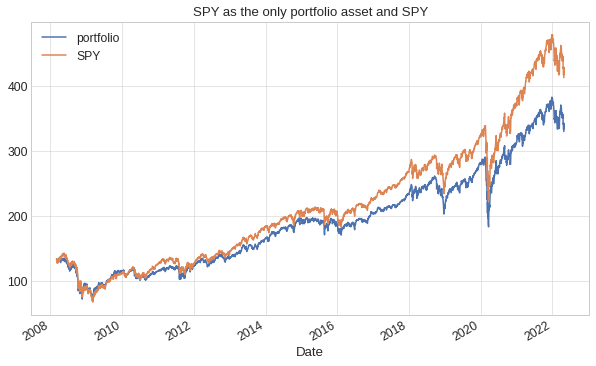

In [5]:
def adjust_time_series(ts_one_df: pd.DataFrame, ts_two_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Adjust two DataFrame time series with overlapping date indices so that they
    are the same length with the same date indices.
    """
    ts_one_index = pd.to_datetime(ts_one_df.index)
    ts_two_index = pd.to_datetime(ts_two_df.index)
        # filter the close prices
    matching_dates = ts_one_index.isin( ts_two_index )
    ts_one_adj = ts_one_df[matching_dates]
    # filter the rf_prices
    ts_one_index = pd.to_datetime(ts_one_adj.index)
    matching_dates = ts_two_index.isin(ts_one_index)
    ts_two_adj = ts_two_df[matching_dates]
    return ts_one_adj, ts_two_adj


def build_plot_data(holdings: float, portfolio_df: pd.DataFrame, spy_df: pd.DataFrame) -> pd.DataFrame:
    port_start_date = portfolio_df.index[0]
    port_start_date = convert_date(port_start_date)
    port_end_date = portfolio_df.index[-1]
    port_end_date = convert_date(port_end_date)
    spy_index = spy_df.index
    spy_start_ix = findDateIndex(spy_index, port_start_date)
    spy_end_ix = findDateIndex(spy_index, port_end_date)
    spy_df = pd.DataFrame(spy_df[:][spy_start_ix:spy_end_ix+1])
    spy_return = return_df(spy_df)
    spy_return_a = apply_return(start_val=holdings, return_df=spy_return)
    spy_port = pd.DataFrame(spy_return_a)
    spy_port.columns = ['SPY']
    spy_port.index = pd.to_datetime(spy_df.index)
    plot_df = portfolio_df.copy()
    plot_df['SPY'] = spy_port
    return plot_df


spy_start_val = float(spy_close[:].values[0])
spy_only_portfolio, t = portfolio_return(holdings=spy_start_val,
                                         risk_asset=spy_close,
                                         bond_asset=spy_close,
                                         spy_data=spy_data,
                                         start_date=start_date,
                                         end_date=end_date)

plot_df = build_plot_data(holdings=spy_start_val, portfolio_df=spy_only_portfolio, spy_df=spy_close)
plot_df.plot(grid=True, title='SPY as the only portfolio asset and SPY', figsize=(10,6))


def collapse_asset_df(asset_df: pd.DataFrame) -> pd.DataFrame:
    row = asset_df[0:1]
    cur_asset = row['asset'][0]
    collapse_df = pd.DataFrame(row)
    for index in range(1, asset_df.shape[0]):
        row = asset_df[:][index:index+1]
        row_name = row['asset'][0]
        if row_name != cur_asset:
            collapse_df = pd.concat([collapse_df, row])
            cur_asset = row_name
    if collapse_df.tail(1).index[0] != asset_df.tail(1).index[0]:
        collapse_df = pd.concat([collapse_df, asset_df.tail(1)])
    return collapse_df


holdings = 100000
cash_trigger_bonds = ['JNK', 'TLT', 'MUB']
cash_trigger_bond_file = "cash_trigger_bond_adjclose"
cash_trigger_bond_adjclose = get_market_data(file_name=cash_trigger_bond_file,
                                             data_col='Adj Close',
                                             symbols=cash_trigger_bonds,
                                             data_source=data_source,
                                             start_date=start_date,
                                             end_date=end_date)

shy_file = "shy_adjclose"
shy_ticker = 'SHY'
shy_sym = [shy_ticker]
shy_adjclose = get_market_data(file_name=shy_file,
                               data_col='Adj Close',
                               symbols=shy_sym,
                               data_source=data_source,
                               start_date=start_date,
                               end_date=end_date)


# Add SHY to the bond set
cash_trigger_bond_adjclose[shy_ticker] = shy_adjclose

spy_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                               risk_asset=spy_close,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=start_date,
                                               end_date=end_date
                                               )


<h2>
Cash Trigger Strategy
</h2>
<p>
The plot below shows the results with the cash trigger strategy using a single risk (equity)
asset, SPY.  When the strategy is "risk off" the strategy invests in one of four
bonds JNK, TLT, MUB or SHY (depending on which had the highest return in the last three
months).
</p>

<AxesSubplot:title={'center':'SPY Portfolio and SPY'}, xlabel='Date'>

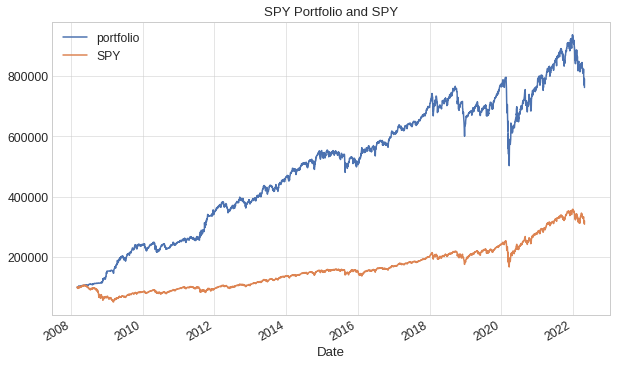

In [6]:
plot_df = build_plot_data(holdings=holdings, portfolio_df=spy_portfolio_df, spy_df=spy_close)
plot_df.plot(grid=True, title='SPY Portfolio and SPY', figsize=(10,6))

<p>
For an investment in 2008, the <i>Cash Trigger</i> strategy has impressive results.
As I learned from analyzing <i>The 12% Solution</i> strategy, one reason that the Cash
Trigger strategy does so much better than the S&P 500 (SPY) is that the strategy portfolio
did have a large loss in the 2008-2009 crash.
</p>

<p>
The table below shows the assets chosen by the strategy in various time periods.  Periods
where an asset is held over multiple months are summarized in a single table entry.
</p>

In [7]:
assets_collapsed_df = collapse_asset_df(assets_df)

print(tabulate(assets_collapsed_df, headers=[*assets_collapsed_df.columns], tablefmt='fancy_grid'))


def calculate_volatility(prices: pd.DataFrame) -> pd.DataFrame:
    sd_a = np.zeros(prices.shape[1])
    for i, col in enumerate(prices.columns):
        ts = prices[col]
        ts_df = pd.DataFrame(ts)
        ts_df.columns = [col]
        ret_df = return_df(ts_df)
        sd = float(round(ret_df.std() * sqrt(trading_days) * 100, 2))
        sd_a[i] = sd
    vol_df = pd.DataFrame(sd_a).transpose()
    vol_df.columns = prices.columns
    vol_df.index =  ['Volatility (yearly percent)']
    return vol_df


vol_df = calculate_volatility(plot_df)

╒═════════════════════╤═════════╕
│                     │ asset   │
╞═════════════════════╪═════════╡
│ 2008-03-03 00:00:00 │ TLT     │
├─────────────────────┼─────────┤
│ 2008-04-01 00:00:00 │ JNK     │
├─────────────────────┼─────────┤
│ 2008-05-01 00:00:00 │ MUB     │
├─────────────────────┼─────────┤
│ 2008-06-02 00:00:00 │ TLT     │
├─────────────────────┼─────────┤
│ 2008-07-01 00:00:00 │ MUB     │
├─────────────────────┼─────────┤
│ 2008-08-01 00:00:00 │ TLT     │
├─────────────────────┼─────────┤
│ 2008-09-02 00:00:00 │ SHY     │
├─────────────────────┼─────────┤
│ 2008-11-03 00:00:00 │ TLT     │
├─────────────────────┼─────────┤
│ 2008-12-01 00:00:00 │ JNK     │
├─────────────────────┼─────────┤
│ 2009-01-02 00:00:00 │ SHY     │
├─────────────────────┼─────────┤
│ 2009-02-02 00:00:00 │ MUB     │
├─────────────────────┼─────────┤
│ 2009-03-02 00:00:00 │ JNK     │
├─────────────────────┼─────────┤
│ 2009-06-01 00:00:00 │ SPY     │
├─────────────────────┼─────────┤
│ 2010-06-01 0

<p>
The volatility of the cash trigger portfolio is less than the volatility of
SPY (the S&P 500), although the return of the portfolio is much higher.
</p>

In [8]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))


def yearly_return(prices: pd.DataFrame) -> pd.DataFrame:
    """
    The yearly return is the return if the asset where purchased on the
    first trading day and sold on the last trading day.
    :param prices: the asset prices for the time period.
    :return: a DataFrame containing the yearly returns for the asset.
    """
    year_periods = find_year_periods(prices)
    year_return_df = pd.DataFrame()
    for ix, period in year_periods.iterrows():
        start_ix = period['start_ix']
        end_ix = period['end_ix']
        start_val = prices[:][start_ix:start_ix + 1].values
        end_val = prices[:][end_ix:end_ix + 1].values
        r = (end_val/start_val) - 1
        r_percent = np.round(r * 100, 2)
        r_df = pd.DataFrame(r_percent)
        r_df.columns = prices.columns
        year_return_df = pd.concat([year_return_df, r_df])
    year_return_df.index = year_periods['year']
    return year_return_df


def yearly_drawdown(prices: pd.DataFrame) -> pd.DataFrame:
    year_periods = find_year_periods(prices)
    drawdown_df = pd.DataFrame()
    for ix, period in year_periods.iterrows():
        start_ix = period['start_ix']
        end_ix = period['end_ix']
        year_df = prices[:][start_ix:end_ix+1]
        year_drawdown = qs.stats.max_drawdown(year_df)
        year_drawdown_df = pd.DataFrame(year_drawdown).transpose()
        drawdown_df = pd.concat([drawdown_df, year_drawdown_df])
    drawdown_df = round(drawdown_df * 100, 2)
    drawdown_df.index = year_periods['year']
    return drawdown_df


def build_drawdown_return(prices: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    year_return_df = yearly_return(prices)
    drawdown_df = yearly_drawdown(prices)
    return_cols = list()
    for col in year_return_df.columns:
        ret_col = f'{col} return'
        return_cols.append(ret_col)
    year_return_df.columns = return_cols
    drawdown_cols = list()
    for col in drawdown_df.columns:
        dd_col = f'{col} drawdown'
        drawdown_cols.append(dd_col)
    drawdown_df.columns = drawdown_cols
    table_df = pd.concat([year_return_df, drawdown_df], axis=1)
    table_mean = pd.DataFrame(table_df.mean()).transpose()
    table_mean.index = ['average']
    return table_df, table_mean


table_df, table_mean = build_drawdown_return(plot_df)

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       15.63 │ 20.57 │
╘═════════════════════════════╧═════════════╧═══════╛


<h3>
Yearly Return and Drawdown from 2008
</h3>
<p>
Drawdown is one measure of investment risk.
Yearly drawdown is the maximum amount that an investment loses, as a percentage, over a one year
period.  If the yearly return is larger than the drawdown, the investment will have a positive
return for the year.
</p>

In [9]:
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))


╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2008 │              52.93 │       -32.4  │                -3.74 │         -47.26 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2009 │              56.67 │        19.88 │                -7.87 │         -27.13 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2010 │               4.24 │        10.96 │               -13.14 │         -16.1  │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2011 │              40.13 │        -1.22 │                -5.46 │         -19.42 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2012 │               9.18 │        11.69 │                -9.61

<p>
The portfolio performance of a portfolio with only SPY as an asset from 2008 is
impressive, beating the S&P 500 (SPY) by a significant multiple.  The portfolio has lower
volatility and has almost twice the average return of the S&P 500, with a lower average
drawdown.
</p>
<p>
As we shall see in the next section, the portfolio performance is due to the fact that
instead of losing money in the 2008-2009 market downturn, the portfolio was profitable.
These gains were increased by compound return.
</p>

<h3>
Cash Trigger Strategy from 2010, with SPY
</h3>

<p>
In evaluating an investment strategy it is important to examine an investment start
after the market crash, when the market has started to recover.  In this section we look
at the cash trigger strategy where the investment starts in 2010.
</p>

In [10]:
d2010_start: datetime = datetime.fromisoformat('2010-01-04')

d2010_spy_close = spy_data.close_data(d2010_start, end_date)
d2010_moving_avg = spy_data.moving_avg(d2010_start, end_date)
plot_df = pd.concat([d2010_spy_close, d2010_moving_avg], axis=1)

<p>
The 200-day moving average and SPY
</p>

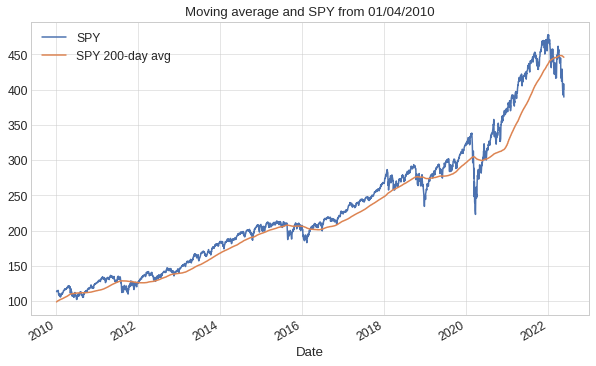

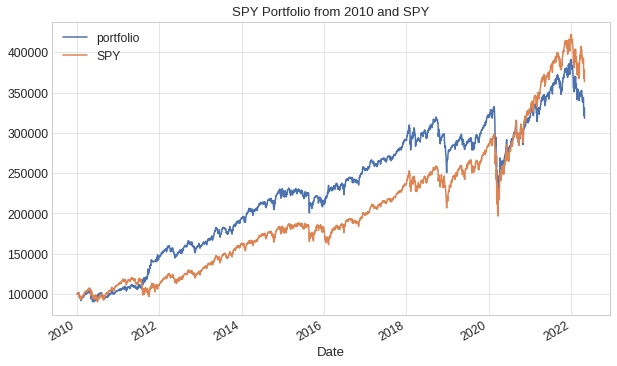

In [11]:
plot_df.plot(grid=True, title=f'Moving average and SPY from {d2010_start.strftime("%m/%d/%Y")}', figsize=(10,6))


d2010_start: datetime = datetime.fromisoformat('2010-01-04')
d2010_spy_portfolio_df, assets_df = portfolio_return(holdings=holdings,
                                               risk_asset=spy_close,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=d2010_start,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=d2010_spy_portfolio_df, spy_df=spy_close)
plot_df.plot(grid=True, title='SPY Portfolio from 2010 and SPY', figsize=(10,6))

vol_df = calculate_volatility(plot_df)

<p>
The volatility of the strategy portfolio and SPY for an investment that starts in 2010
are shown below.  The strategy is slightly
less volatile.  As the plot shows, the final portfolio value is less than SPY.
</p>

In [12]:
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │        15.4 │ 17.17 │
╘═════════════════════════════╧═════════════╧═══════╛


<p>
The yearly return and drawdowns are shown below.
</p>

In [13]:
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))

╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2010 │               4.24 │        10.96 │               -13.14 │         -16.1  │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2011 │              40.13 │        -1.22 │                -5.46 │         -19.42 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2012 │               9.18 │        11.69 │                -9.61 │          -9.69 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2013 │              22.01 │        26.45 │                -6.56 │          -6.05 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2014 │              16.83 │        12.37 │                -6.44

<p>
The strategy has slightly less risk (shown by the volatility and the maximum drawdown), but
also slightly less return compared to the S&P 500.
</p>

<h3>
SPY only Portfolio performace over the last 5-years
</h3>

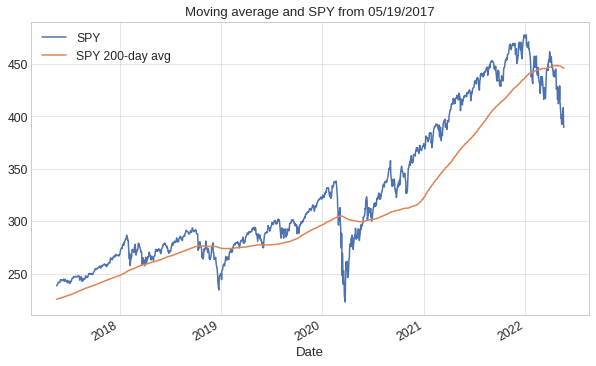

In [14]:
d5_year_start = end_date - relativedelta(years=5)
d5_spy_close = spy_data.close_data(d5_year_start, end_date)
d5_moving_avg = spy_data.moving_avg(d5_year_start, end_date)
plot_df = pd.concat([d5_spy_close, d5_moving_avg], axis=1)

plot_df.plot(grid=True, title=f'Moving average and SPY from {d5_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

five_year_spy_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=spy_close,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=d5_year_start,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=five_year_spy_portfolio_df, spy_df=spy_close)

<p>
The SPY only portfolio using the strategy is shown below.
</p>

<AxesSubplot:title={'center':'SPY Portfolio from 05/19/2017 and SPY'}, xlabel='Date'>

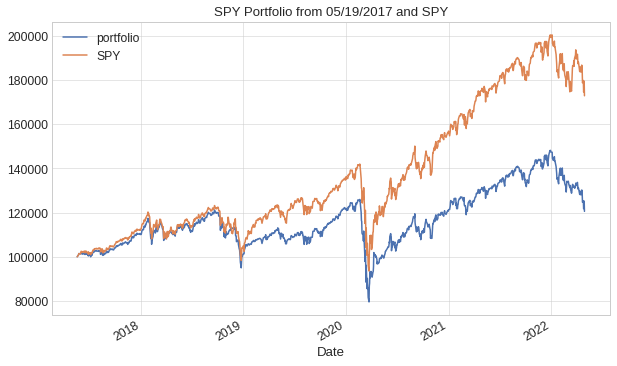

In [15]:
plot_df.plot(grid=True, title=f'SPY Portfolio from {d5_year_start.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

<p>
The portfolio statistics are shown below:
</p>

In [16]:
vol_df = calculate_volatility(plot_df)
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       18.39 │  19.8 │
╘═════════════════════════════╧═════════════╧═══════╛
╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2017 │              10.11 │        11.98 │                -2.13 │          -2.08 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2018 │              -7.99 │        -7.01 │               -21.62 │         -20.18 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2019 │              20.27 │        28.65 │                -6.61 │          -6.62 │
├──────┼────────────────────┼──────────────┼──────

<h3>
SPY only Portfolio performace over the last 3-years
</h3>

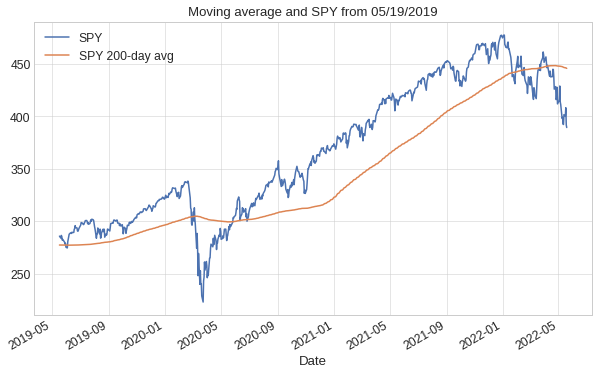

In [17]:
d3_year_start = end_date - relativedelta(years=3)

d3_spy_close = spy_data.close_data(d3_year_start, end_date)
d3_moving_avg = spy_data.moving_avg(d3_year_start, end_date)
plot_df = pd.concat([d3_spy_close, d3_moving_avg], axis=1)

plot_df.plot(grid=True, title=f'Moving average and SPY from {d3_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))


three_year_spy_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=spy_close,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=d3_year_start,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=three_year_spy_portfolio_df, spy_df=spy_close)

<p>
The SPY only portfolio using the strategy is shown below.
</p>

<AxesSubplot:title={'center':'SPY Portfolio from 05/19/2019 and SPY'}, xlabel='Date'>

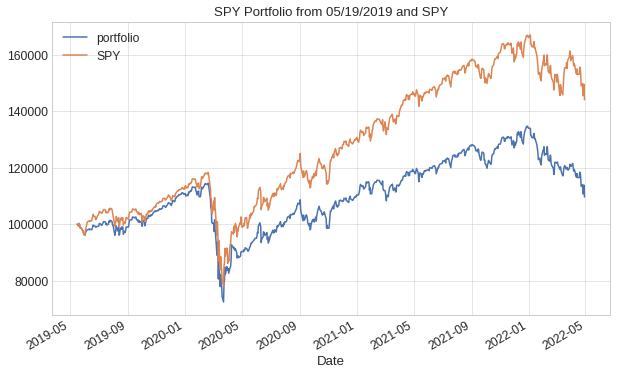

In [18]:
plot_df.plot(grid=True, title=f'SPY Portfolio from {d3_year_start.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

<p>
The portfolio statistics are shown below:
</p>

In [19]:
vol_df = calculate_volatility(plot_df)
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       21.58 │ 22.96 │
╘═════════════════════════════╧═════════════╧═══════╛
╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2019 │              10.82 │        12.6  │                -5.2  │          -6.02 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2020 │              -0.4  │        15.09 │               -36.84 │         -34.1  │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2021 │              21.44 │        28.79 │                -6.53 │          -5.42 │
├──────┼────────────────────┼──────────────┼──────

<h3>
SPY only Portfolio performace over the last year
</h3>

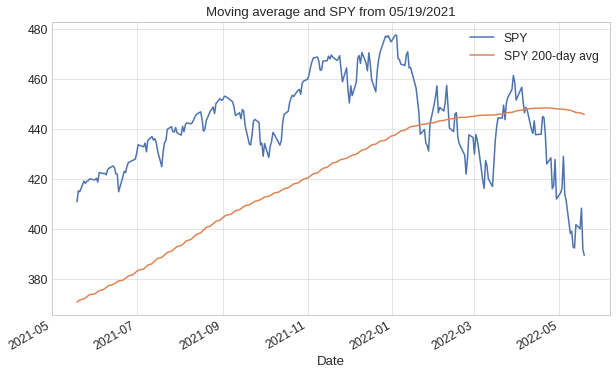

In [20]:
d1_year_start = end_date - relativedelta(years=1)

d1_spy_close = spy_data.close_data(d1_year_start, end_date)
d1_moving_avg = spy_data.moving_avg(d1_year_start, end_date)
plot_df = pd.concat([d1_spy_close, d1_moving_avg], axis=1)

plot_df.plot(grid=True, title=f'Moving average and SPY from {d1_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))


one_year_spy_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=spy_close,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=d1_year_start,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=one_year_spy_portfolio_df, spy_df=spy_close)

<p>
The SPY only portfolio using the strategy is shown below.
</p>

<AxesSubplot:title={'center':'SPY Portfolio from 05/19/2021 and SPY'}, xlabel='Date'>

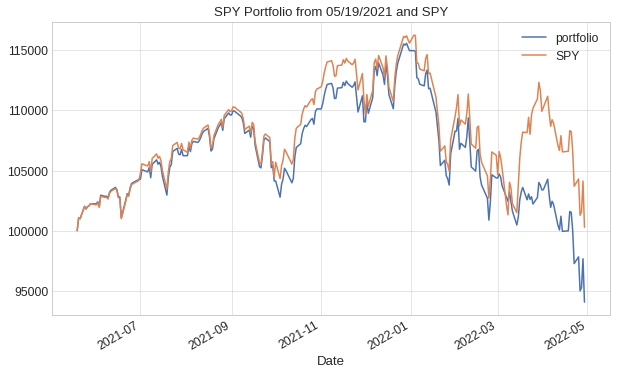

In [21]:
plot_df.plot(grid=True, title=f'SPY Portfolio from {d1_year_start.strftime("%m/%d/%Y")} and SPY', figsize=(10,6))

<p>
The portfolio statistics are shown below:
</p>

In [22]:
vol_df = calculate_volatility(plot_df)
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       15.05 │  16.4 │
╘═════════════════════════════╧═════════════╧═══════╛
╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2021 │              14.97 │        15.6  │                -6.53 │          -5.42 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2022 │             -18.2  │       -13.76 │               -18.2  │         -13.76 │
╘══════╧════════════════════╧══════════════╧══════════════════════╧════════════════╛
╒═════════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│         │   portfolio return │   SPY return │

<h3>
Cash Trigger Portfolio Performance with SPY
</h3>
<p>
The backtests for the <i>Cash Trigger</i> strategy shows that the strategy had exceptional
returns for an investment in 2008.  For investments that started at later times the portfolio
return and risk was either similar to SPY (for an investment in 2010) or worse than SPY
for later periods. The <i>Cash Trigger</i> portfolio performance has been
particularly bad in the last three years, when the market has been very volatile and the
strategy has done worse than SPY.  If this strategy were used by a manager of an investment
fund over the last five years, they might have been fired.
</p>
<p>
David Alan Carter writes that the attraction of the <i>Cash Trigger</i> strategy is that it
may save your investment portfolio from significant losses in a downturns like the 2008-2009 "great
recession".  As a long-term investment strategy the SPY underperformance is
"worth the price of admission" to avoid significant market downturn. The prices of admission
here is underperformance strategy investments made in the last decade or so, compared to SPY.
</p>
<p>
Backtests like those in this notebook show how a particular strategy would have performed in the past.
The future cannot be known, so backtest results are the best we can do. Backtest results are
meaningful to the extent that the future resembles the past. We do not know if future downturns
will resemble the 2008-2009 downturn.
</p>

<h2>
Strategy Performance with a Mixed Set of ETFs
</h2>
<p>
This section looks at the performance of the strategy applied to an equity portfolio composed of
four ETFs: VV, VO, VB and SOXX. An equally weighted portfolio of these four ETFs are used
for the "risk-on" periods. For the "risk-off" periods, the same bond assets
are used.
</p>
<p>
The four ETFs are briefly described below.
</p>

<ul>
<li>
VV: Vanguard Large-Cap ETF
</li>
<ul>
<li>
VV tracks a market-cap-weighted index that covers 85% of the market
capitalization of the US equity market.
</li>
<li>
Inception date: 01/27/04
</li>
</ul>
</li>
<li>
VO: Vanguard Mid-Cap ETF
</li>
<ul>
<li>
VO tracks the CRSP US Mid Cap Index, a diversified index of mid-cap US companies.
</li>
<li>
Inception date: 01/26/04
</li>
</ul>
</li>
<li>
VB: Vanguard Small-Cap ETF
</li>
<ul>
<li>
VB tracks the CRSP US Small Cap Index. The market-cap-weighted index includes the
bottom 2-15% of the investable universe.
</li>
<li>
Inception date: 01/26/04
</li>
</ul>
</li>
<li>
SOXX: iShares Semiconductor ETF
</li>
<ul>
<li>
SOXX tracks a modified market-cap-weighted index of 30 US-listed semiconductor companies.
</li>
<li>
Inception date: 07/10/01
</li>
</ul>
</li>
</ul>

In [23]:
market_etfs = ['SOXX', 'VV', 'VO', 'VB']

market_etf_file = "market_etf_adjclose"
market_etf_adjclose = get_market_data(file_name=market_etf_file,
                                      data_col='Adj Close',
                                      symbols=market_etfs,
                                      data_source=data_source,
                                      start_date=start_date,
                                      end_date=end_date)

<h3>
Calculating ETF Portfolio Value
</h3>

<p>
To calculate the portfolio value for the four ETF we start with an investment balance. It doesn't
matter what this balance is, so we'll use $100,000.  Each asset is invested with equal weight,
25% per asset.  The return for each asset is calculated and applied to the initial investment.
The portfolio is rebalanced every year so the ETF proportions remain around 25%. The results
in <a href="https://github.com/IanLKaplan/all_weather_portfolio/blob/master/all_weather_portfolio.ipynb"><i>All Weather Portfolio</i></a>
suggest that the portfolio should not get too out of balance over
a one year period.
</p>
<p>
The result will be a price series which can be used to in the <i>Cash Trigger</i> strategy.
When the strategy is "risk-on" the portfolio will be invested in the
ETF assets.  When the strategy is "risk-off" the portfolio will be invested in bonds.
</p>

In [24]:
def calc_asset_portfolio(holdings: float, prices_df: pd.DataFrame, weights: np.array) -> pd.DataFrame:
    """
     Given a set of asset prices and weights, return a DataFrame where each column contains
     a price series for the asset, starting with a weighted portfolio investment. For example,
     if the weights are [0.25, 0.25, 0.25, 0.25] and the initial holding is 100,000 the
     initial prices series will be the returns for each asset applied to 25,000. The
     portfolio will be rebalanced every year, so the weights will be approximately
     maintained.
    :param holdings: the initial value invested in the portfolio
    :param prices_df: a DataFrame containing a price series for the portfolio assets
    :param weights: The weights for the various assets
    :return: The prices series for the yearly rebalanced assets.
    """
    start_balance = holdings * weights
    portfolio_df = pd.DataFrame()
    year_periods = find_year_periods(prices_df)
    # columns=['start_ix', 'end_ix', 'year']
    for ix, period in year_periods.iterrows():
        start_ix = period['start_ix']
        end_ix = period['end_ix']
        year_prices_df = prices_df[:][start_ix:end_ix+1]
        year_return = return_df(year_prices_df)
        year_portfolio_df = pd.DataFrame([[], [], [], []]).transpose()
        year_portfolio_df.columns = prices_df.columns
        for jx, col in enumerate(year_prices_df.columns):
            col_prices_a = apply_return(start_balance[jx], year_return[col])
            year_portfolio_df[col] = pd.DataFrame(col_prices_a)
        year_total = year_portfolio_df.tail(1).values.sum()
        # rebalanced every year
        start_balance = year_total * weights
        portfolio_df = pd.concat([portfolio_df, year_portfolio_df])
    date_index = prices_df.index
    portfolio_df.index = date_index
    return portfolio_df



etf_weights = np.full(market_etf_adjclose.shape[1], 0.25)
portfolio_prices = calc_asset_portfolio(holdings=holdings, prices_df=market_etf_adjclose, weights=etf_weights)
portfolio_sum_s = portfolio_prices.sum(axis=1)
portfolio_sum_df = pd.DataFrame(portfolio_sum_s)
portfolio_sum_df.columns = ['portfolio']
plot_df = build_plot_data(holdings=holdings, portfolio_df=portfolio_sum_df, spy_df=spy_close)

<p>
The equally weighted portfolio of the four ETFs is plotted below.
</p>

<AxesSubplot:title={'center':'4-ETF Portfolio and SPY'}, xlabel='Date'>

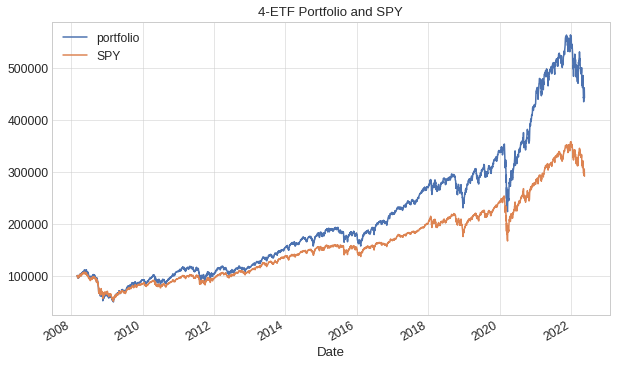

In [25]:
plot_df.plot(grid=True, title='4-ETF Portfolio and SPY', figsize=(10,6))

<p>
The statistics for a non-cash trigger investment in the 4-ETF portfolio are shown below.
</p>

In [26]:
vol_df = calculate_volatility(plot_df)
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))


four_etf_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=portfolio_sum_df,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=start_date,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=four_etf_portfolio_df, spy_df=spy_close)

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       23.24 │ 20.64 │
╘═════════════════════════════╧═════════════╧═══════╛
╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2008 │             -34.87 │       -32.4  │               -53.61 │         -47.26 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2009 │              40.14 │        19.88 │               -25.77 │         -27.13 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2010 │              18.78 │        10.96 │               -17.68 │         -16.1  │
├──────┼────────────────────┼──────────────┼──────

<p>
The <i>Cash Trigger</i> strategy applied to the 4-ETF portfolio for the "risk-on" periods
is shown below for an investment starting in 2008.  These results are spectacular. An investment
of $100,000 would have resulted in a portfolio balance of over a million dollars.
</p>

<AxesSubplot:title={'center':'4-ETF Portfolio with Cash Trigger and SPY'}, xlabel='Date'>

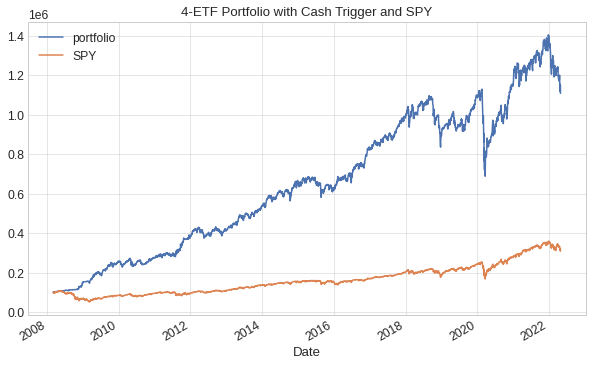

In [27]:
plot_df.plot(grid=True, title='4-ETF Portfolio with Cash Trigger and SPY', figsize=(10,6))

<p>
The portfolio statistics are shown below.
</p>

In [28]:
vol_df = calculate_volatility(plot_df)
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))

five_year_etf_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=portfolio_sum_df,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=d5_year_start,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=five_year_etf_portfolio_df, spy_df=spy_close)

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       17.65 │ 20.57 │
╘═════════════════════════════╧═════════════╧═══════╛
╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2008 │              52.93 │       -32.4  │                -3.74 │         -47.26 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2009 │              66.24 │        19.88 │                -9.56 │         -27.13 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2010 │               8.26 │        10.96 │               -14.98 │         -16.1  │
├──────┼────────────────────┼──────────────┼──────

<p>
As we have seen with previous examples in this notebook, investments that are made after 2009
do not do as well.  The plot below shows the 4-ETF assets in an investment over the last
five years.
</p>

<AxesSubplot:title={'center':'4-ETF and SPY with cash trigger past 5 years from 05/19/2017'}, xlabel='Date'>

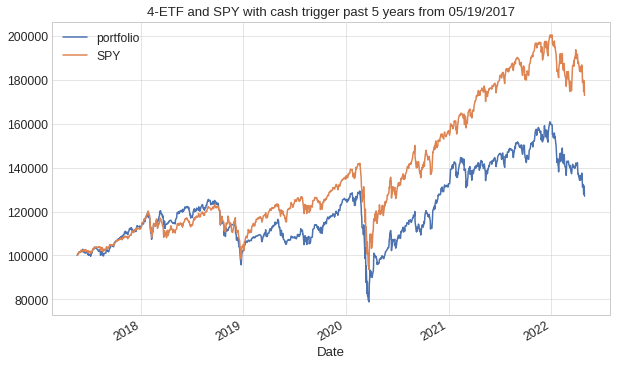

In [29]:
plot_df.plot(grid=True, title=f'4-ETF and SPY with cash trigger past 5 years from {d5_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
The portfolio statistics are shown below. By every measure the 4-ETF portfolio with the <i>Cash
Trigger</i> strategy performs worse than SPY.
</p>

In [30]:
vol_df = calculate_volatility(plot_df)
print(tabulate(vol_df, headers=[*vol_df.columns], tablefmt='fancy_grid'))

table_df, table_mean = build_drawdown_return(plot_df)
print(tabulate(table_df, headers=[*table_df.columns], tablefmt='fancy_grid'))

print(tabulate(table_mean, headers=[*table_mean.columns], tablefmt='fancy_grid'))

╒═════════════════════════════╤═════════════╤═══════╕
│                             │   portfolio │   SPY │
╞═════════════════════════════╪═════════════╪═══════╡
│ Volatility (yearly percent) │       21.02 │  19.8 │
╘═════════════════════════════╧═════════════╧═══════╛
╒══════╤════════════════════╤══════════════╤══════════════════════╤════════════════╕
│      │   portfolio return │   SPY return │   portfolio drawdown │   SPY drawdown │
╞══════╪════════════════════╪══════════════╪══════════════════════╪════════════════╡
│ 2017 │              12.7  │        11.98 │                -3.92 │          -2.08 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2018 │              -9.17 │        -7.01 │               -23.75 │         -20.18 │
├──────┼────────────────────┼──────────────┼──────────────────────┼────────────────┤
│ 2019 │              22.6  │        28.65 │                -9.88 │          -6.62 │
├──────┼────────────────────┼──────────────┼──────

<h2>
The Cash Trigger combined with ETF Rotation
</h2>
<p>
ETF rotation stratagies are explored in <a href="https://github.com/IanLKaplan/twelve_percent/blob/master/twelve_percent.ipynb"><i>ETF Rotation by Ian Kaplan</i></a>.
In this section I explore the ETF rotation strategy combined with the cash trigger signal.
</p>
<p>
The ETF rotation strategy uses a portfolio composed of 60% stock and 40% bonds.
Each portfolio component has a set of equity or bond ETFs that are selected on the basis
of the highest return over the last three months.
</p>
<p>
The strategy explored in this section does not have the dedicated 40% bond component.
When the cash trigger is "risk-on" all of the portfolio assets will be invested in
one of the four equity ETF (IWM, MDY, QQQ or SPY) or SHY, based on their relative performance.
When the cash trigger is "risk-off" the entire portfolio will be invested in
one of four bond assets (JNK, TLT, MUB or SHY).
</p>
<h2>
The ETF Rotation Set
</h2>
<p>
One of the surprises from the ETF rotation notebook is that I did not find an ETF
set that performed better than IWM, MDY, QQQ and SPY (in combination with SHY). This
ETF set is used in the strategy that combines the cash trigger with ETF rotation.
</p>
<h3>
Equity ETFs
</h3>
<ul>
<li>
<p>
IWM: iShares Russell 2000 ETF
</p>
<p>
IWM tracks a market-cap-weighted index of US small-cap stocks. The index selects
stocks ranked 1,001-3,000 by market cap.
</p>
<p>
Inception date: 5/22/2000
</p>
</li>
<li>
<p>
MDY: SPDR S&P Midcap 400 ETF Trust
</p>
<p>
MDY tracks a market-cap-weighted index of midcap US companies.
</p>
<p>
Inception date: 5/04/1995
</p>
</li>
<li>
<p>
QQQ: Invesco QQQ Trust
</p>
<p>
QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
</p>
<p>
Inception date: 3/10/1999
</p>
</li>
<li>
<p>
SPY: SPDR S&P 500 ETF Trust
</p>
<p>
SPY tracks a market-cap-weighted index of US large- and midcap stocks selected by
the S&P Committee (e.g., S&P 500).
</p>
<p>
Inception date: Jan 22, 1993
</p>
</li>
</ul>

In [31]:
def percent_return_df(start_date: datetime, end_date: datetime, prices_df: pd.DataFrame) -> pd.DataFrame:
    def percent_return(time_series: pd.Series) -> pd.Series:
        return list(((time_series[i] / time_series[0]) - 1.0 for i in range(0, len(time_series))))


    date_index = prices_df.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    period_df = prices_df[:][start_ix:end_ix+1]
    period_return_df = pd.DataFrame()
    for col in period_df.columns:
        return_series = percent_return(period_df[col])
        period_return_df[col] = return_series
    period_return_df.index = period_df.index
    return_percent_df = round(period_return_df * 100, 2)
    return return_percent_df


# We already have the bond set JNK, TLT, MUB or SHYin the DataFrame cash_trigger_bond_adjclose
# We already have SPY close prices. For consistency we'll use close prices, instead of
# adjusted close prices for IWM, MDY and QQQ.

rotation_etfs = ['IWM', 'MDY', 'QQQ']
rotation_etf_file = 'rotation_etf_close'
rotation_etf_close = get_market_data(file_name=rotation_etf_file,
                                      data_col='Close',
                                      symbols=rotation_etfs,
                                      data_source=data_source,
                                      start_date=start_date,
                                      end_date=end_date)

# SPY has already been downloaded. So add SPY to the rotation_etf_close set.
rotation_etf_close['SPY'] = spy_close
# Add SHY (the cash proxy bond) to the ETF rotation set.
rotation_etf_shy = rotation_etf_close.copy()
rotation_etf_shy[shy_ticker] = shy_adjclose

<h3>
The ETF Rotation: The Equity ETFs
</h3>

<p>
The plot below shows the percentage return since 2008 for the four equity ETFs in the ETF
rotation set.
</p>
<p>
This plot shows that the QQQ ETF has a higher return than the other ETFs.
</p>
<p>
In addition to showing us the relative performance of the four ETFs this plot shows
that we have valid data for the ETF set.
</p>

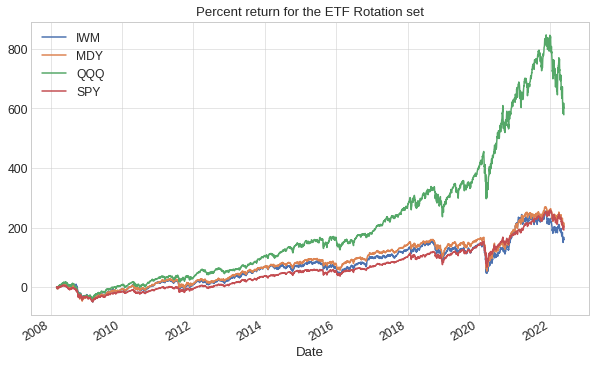

In [32]:
percent_ret = percent_return_df(start_date=start_date,
                                end_date=end_date,
                                prices_df=rotation_etf_close)
percent_ret.plot(grid=True, title='Percent return for the ETF Rotation set', figsize=(10,6))


etf_rotation_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=rotation_etf_shy,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=start_date,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings,
                          portfolio_df=etf_rotation_portfolio_df,
                          spy_df=spy_close)

<h3>
This has to be wrong... (except it's not)
</h3>
<p>
The plot below shows the <i>Cash Trigger</i> strategy combined with the ETF rotation
strategy for an investment starting in 2008.
</p>

Text(0, 0.5, 'Log10')

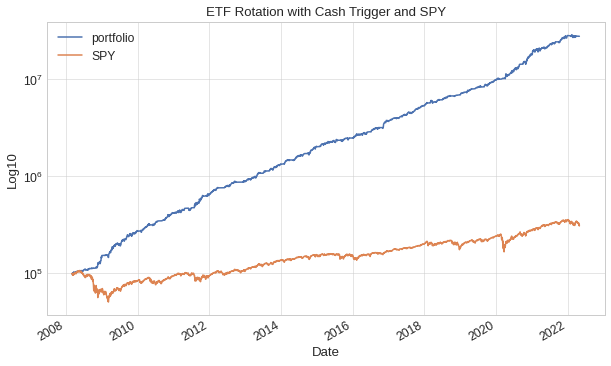

In [33]:
ax = plot_df.plot(grid=True,
             title='ETF Rotation with Cash Trigger and SPY', figsize=(10,6),
             logy=True)
ax.set_ylabel("Log10")

<p>
The ETF rotation strategy combined with the cash trigger beats the S&P 500 by a huge margin.
The results are so large that the y-axis is plotted in a log 10 scale.
</p>
<p>
The final values for the cash trigger/ETF rotation portfolio and SPY are shown below.
</p>

In [34]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))

╒═════════════════════╤═════════════╤════════╕
│                     │   portfolio │    SPY │
╞═════════════════════╪═════════════╪════════╡
│ 2022-04-29 00:00:00 │    27406954 │ 308614 │
╘═════════════════════╧═════════════╧════════╛


<p>
The final portfolio value is so large (insane) that my reaction was that there must be an error
in the code to calculate the portfolio values.
</p>

In [35]:
five_year_etf_rotation_portfolio_df, t = portfolio_return(holdings=holdings,
                                               risk_asset=rotation_etf_shy,
                                               bond_asset=cash_trigger_bond_adjclose,
                                               spy_data=spy_data,
                                               start_date=d5_year_start,
                                               end_date=end_date
                                               )

plot_df = build_plot_data(holdings=holdings, portfolio_df=five_year_etf_rotation_portfolio_df, spy_df=spy_close)

<p>
Basing the analysis of a strategy on an investment that
starts in 2008 can be misleading, since the compound return from avoiding the 2008-2009
downturn can bias the results.
</p>
<p>
The plot below shows an investment in the past five years.
</p>

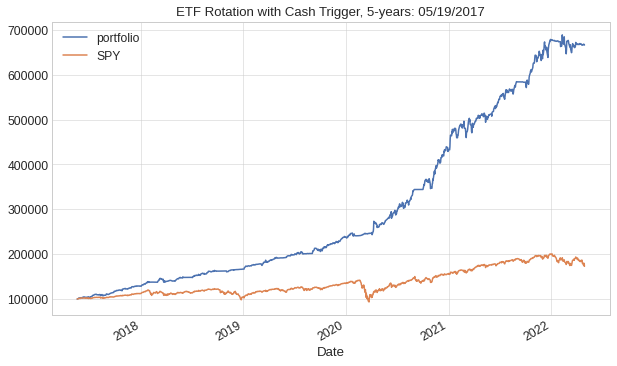

In [36]:
plot_df.plot(grid=True, title=f'ETF Rotation with Cash Trigger, 5-years: {d5_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

one_year_etf_rotation_portfolio_df, one_year_assets = portfolio_return(holdings=holdings,
                                                                       risk_asset=rotation_etf_shy,
                                                                       bond_asset=cash_trigger_bond_adjclose,
                                                                       spy_data=spy_data,
                                                                       start_date=d1_year_start,
                                                                       end_date=end_date
                                                                       )

<p>
The plot below shows an investment over the past year.
</p>

<AxesSubplot:title={'center':'ETF Rotation with Cash Trigger, 1-year: 05/19/2021'}, xlabel='Date'>

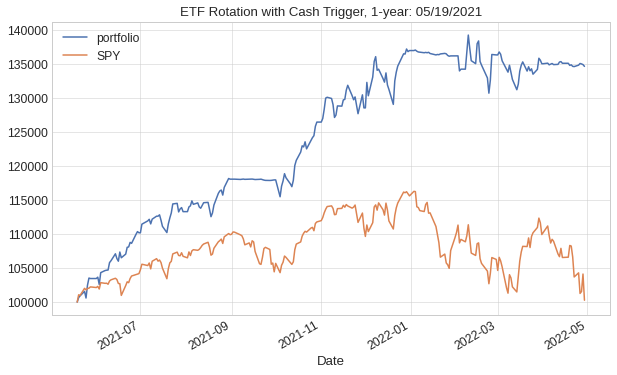

In [37]:
plot_df = build_plot_data(holdings=holdings, portfolio_df=one_year_etf_rotation_portfolio_df, spy_df=spy_close)
plot_df.plot(grid=True, title=f'ETF Rotation with Cash Trigger, 1-year: {d1_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
The assets over the last one year period are:
</p>

In [38]:
print(tabulate(one_year_assets, headers=[*one_year_assets.columns], tablefmt='fancy_grid'))

╒═════════════════════╤═════════╕
│                     │ asset   │
╞═════════════════════╪═════════╡
│ 2021-05-19 00:00:00 │ IWM     │
├─────────────────────┼─────────┤
│ 2021-06-01 00:00:00 │ QQQ     │
├─────────────────────┼─────────┤
│ 2021-07-01 00:00:00 │ QQQ     │
├─────────────────────┼─────────┤
│ 2021-08-02 00:00:00 │ QQQ     │
├─────────────────────┼─────────┤
│ 2021-09-01 00:00:00 │ SHY     │
├─────────────────────┼─────────┤
│ 2021-10-01 00:00:00 │ QQQ     │
├─────────────────────┼─────────┤
│ 2021-11-01 00:00:00 │ QQQ     │
├─────────────────────┼─────────┤
│ 2021-12-01 00:00:00 │ MDY     │
├─────────────────────┼─────────┤
│ 2022-01-03 00:00:00 │ SHY     │
├─────────────────────┼─────────┤
│ 2022-02-01 00:00:00 │ MDY     │
├─────────────────────┼─────────┤
│ 2022-03-01 00:00:00 │ JNK     │
├─────────────────────┼─────────┤
│ 2022-04-01 00:00:00 │ SHY     │
╘═════════════════════╧═════════╛


<h3>
Validating the results
</h3>
<p>
I have been writing software for a long time.  This has taught me that there is always
the possibility of errors in the code. Errors can be difficult to find in computatonal
finance code since the errors can be subtle.
</p>
<p>
In this section the portfolio return for the ETF rotation/cash trigger code is
calculated using another set of functions. This code is designed to mirror
the returns that would be realized in actual trading.
</p>
<p>
Up to this point, all of the examples in this notebook use continuously compounded
returns. The return for each day is applied to the current portfolio balance. This
allows continuous plots to be generated, but it does not mirror how assets would
actually be traded in a real portfolio.
</p>
<p>
In a real portfolio the ETF rotation/cash trigger strategy would be used to calculate
the asset that would be purchased for the current month. The asset is held until
the end of the month, when the asset calculation is repeated. If the calculation results
in the same asset, the asset is held through the next month. Otherwise, the asset is
sold and a new asset is purchased.
</p>
<p>
If the portfolio backtest results in this section are similar to the results previously
calculated then we can have confidence in the previous results. If there is a significant
difference then this needs to be investigated.
</p>

In [39]:
def get_asset_investments(risk_asset: pd.DataFrame,
                          bond_asset: pd.DataFrame,
                          spy_data: SpyData,
                          start_date: datetime,
                          end_date: datetime) -> pd.DataFrame:
    """
    :param risk_asset: the risk asset set
    :param bond_asset: the bond asset set
    :param spy_data:  SpyData object
    :param start_date: the start date for the period over which the calculation is performed.
    :param end_date: the end date for the period over which the calculation is performed.
    :return: a data frame with the columns: asset, start_date, end_date and risk-on.
            The asset will be the asset symbol (e.g., 'SPY', 'QQQ', etc)  The
            start date will be the start_date on which the asset should be purchased.
            The date is an ISO date in string format. The end_date is the date that
            the asset should be sold. The risk-on column contains True or False values.
            If the value is True, then the period is "risk-on".
    """
    name_l: List = []
    risk_l: List = []
    date_l: List = []
    end_date_l: List = []
    month_periods = find_month_periods(start_date, end_date, risk_asset)
    for index, period in month_periods.iterrows():
        start_ix = period['start_ix']
        end_ix = period['end_ix']
        period_start_date: datetime = convert_date(period['start_date'])
        period_end_date: datetime = convert_date(period['end_date'])
        date_l.append(period_start_date)
        end_date_l.append(period_end_date)
        asset_name = ''
        if spy_data.risk_state(period_start_date) == RiskState.RISK_ON:
            asset_name: str = chooseAssetName(start_ix, end_ix, risk_asset)
            risk_on: bool = True
        else:  # RISK_OFF - bonds
            asset_name: str = chooseAssetName(start_ix, end_ix, bond_asset)
            risk_on: bool = False
        name_l.append(asset_name)
        risk_l.append(risk_on)
    asset_df = pd.DataFrame([name_l, date_l, end_date_l, risk_l]).transpose()
    asset_df.index = date_l
    asset_df.columns = ['asset', 'start_date', 'end_date', 'risk-on']
    asset_df = collapse_asset_df(asset_df=asset_df)
    return asset_df


def investment_return(holdings: float, investment_df: pd.DataFrame, prices_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate a portfolio time series using the asset and investment periods in investment_df.
    The assets are purchased at the start of th period and sold at the end of the period.
    This mirrors how the assets would actually be traded.

    :param holdings: the portfolio initial start value (for example, 100000)
    :param investment_df: a DataFrame constructed by get_asset_investments
    :param prices_df: a data frame containing all of the assets (equity and bond ETFs)
    :return: the portfolio time series.
    """
    date_index = prices_df.index
    date_l: List = []
    prices_l: List = []
    balance = holdings
    first = True
    for ix, row in investment_df.iterrows():
        start_date = row['start_date']
        end_date = row['end_date']
        if first:
            prices_l.append(balance)
            date_l.append(start_date)
            first = False
        asset = row['asset']
        start_ix = findDateIndex(date_index, start_date)
        end_ix = findDateIndex(date_index, end_date)
        assert start_ix >= 0 and end_ix >= 0
        row_one = prices_df[asset][start_ix:start_ix+1]
        row_n = prices_df[asset][end_ix:end_ix+1]
        value_n = row_n.values[0]
        value_1 = row_one.values[0]
        r = (value_n / value_1) -1
        # we can only buy whole shares
        num_shares = balance // value_1
        equity_balance = num_shares * value_1
        cash_balance = balance - equity_balance
        equity_return = equity_balance + equity_balance * r
        balance = equity_return + cash_balance
        prices_l.append(balance)
        date_l.append(end_date)
    portfolio_df = pd.DataFrame(prices_l)
    portfolio_df.index = date_l
    portfolio_df.columns = ['portfolio']
    return portfolio_df

all_assets = pd.concat([rotation_etf_close, cash_trigger_bond_adjclose], axis=1)

asset_df = get_asset_investments(risk_asset=rotation_etf_shy,
                                 bond_asset=cash_trigger_bond_adjclose,
                                 spy_data=spy_data,
                                 start_date=start_date,
                                 end_date=end_date
                                 )

new_portfolio_df = investment_return(holdings=holdings,
                                     investment_df=asset_df,
                                     prices_df=all_assets)

new_portfolio_adj_df, spy_period_adj = adjust_time_series(new_portfolio_df, spy_close)

plot_df = build_plot_data(holdings=holdings, portfolio_df=new_portfolio_adj_df, spy_df=spy_period_adj)

<h4>
New Portfolio, investment in 2008
</h4>
<p>
The plot below shows the portfolio calculated via period returns, instead of continuously
compounded returns.
</p>

Text(0, 0.5, 'log 10')

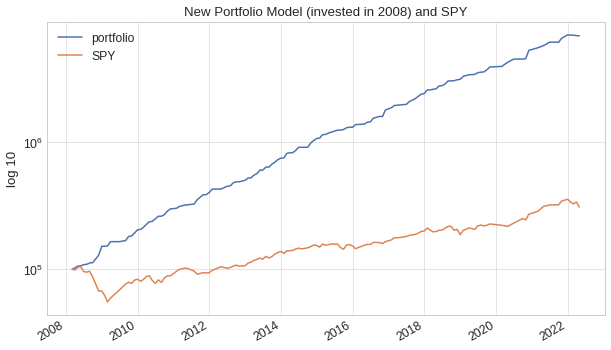

In [40]:
ax = plot_df.plot(grid=True, title='New Portfolio Model (invested in 2008) and SPY', figsize=(10,6), logy=True)
ax.set_ylabel('log 10')

<p>
The final values for the portfolio and SPY are:
</p>

In [41]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))

╒═════════════════════╤═════════════╤════════╕
│                     │   portfolio │    SPY │
╞═════════════════════╪═════════════╪════════╡
│ 2022-04-29 00:00:00 │     6858701 │ 308614 │
╘═════════════════════╧═════════════╧════════╛


<p>
The final portfolio value is smaller by about a factor of four than the continuously
compounded returns. The continuously compounded returns are compounded every day, while
the returns in the "new portfolio" are compounded on every trading period.
</p>
<p>
The final portfolio values in both cases are in the millions.
This can be viewed as validating the continuously compounded result, since they are
in the same order of magnitude.
</p>

In [42]:
d10_year_start = end_date - relativedelta(years=10)

asset_df = get_asset_investments(risk_asset=rotation_etf_shy,
                                 bond_asset=cash_trigger_bond_adjclose,
                                 spy_data=spy_data,
                                 start_date=d10_year_start,
                                 end_date=end_date
                                 )

new_portfolio_df = investment_return(holdings=holdings,
                                     investment_df=asset_df,
                                     prices_df=all_assets)

new_portfolio_adj_df, spy_period_adj = adjust_time_series(new_portfolio_df, spy_close)

plot_df = build_plot_data(holdings=holdings, portfolio_df=new_portfolio_adj_df, spy_df=spy_period_adj)

<h3>
Past 10-years
</h3>

<AxesSubplot:title={'center':'New Portfolio (ten years) and SPY from 05/19/2012'}>

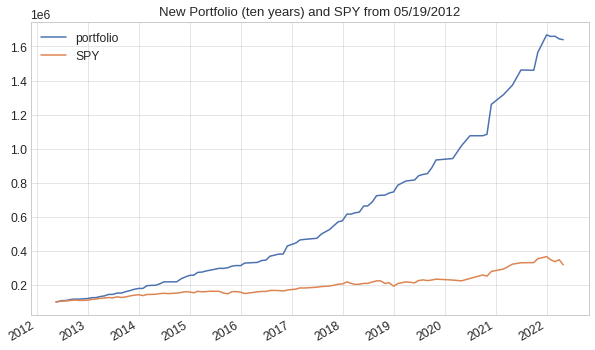

In [43]:
plot_df.plot(grid=True, title=f'New Portfolio (ten years) and SPY from {d10_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
Final portfolio values for the ten year investment:
</p>

In [44]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))


asset_df = get_asset_investments(risk_asset=rotation_etf_shy,
                                 bond_asset=cash_trigger_bond_adjclose,
                                 spy_data=spy_data,
                                 start_date=d5_year_start,
                                 end_date=end_date
                                 )

new_portfolio_df = investment_return(holdings=holdings,
                                     investment_df=asset_df,
                                     prices_df=all_assets)

new_portfolio_adj_df, spy_period_adj = adjust_time_series(new_portfolio_df, spy_close)

plot_df = build_plot_data(holdings=holdings, portfolio_df=new_portfolio_adj_df, spy_df=spy_period_adj)

╒═════════════════════╤═════════════╤════════╕
│                     │   portfolio │    SPY │
╞═════════════════════╪═════════════╪════════╡
│ 2022-04-29 00:00:00 │     1639883 │ 317558 │
╘═════════════════════╧═════════════╧════════╛


<h3>
Past 5-years
</h3>

<AxesSubplot:title={'center':'New Portfolio and SPY from 05/19/2017'}>

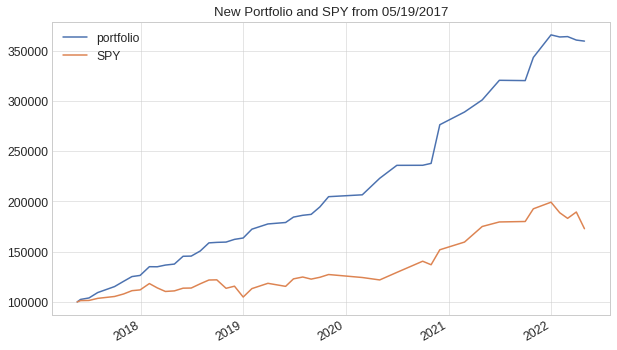

In [45]:
plot_df.plot(grid=True, title=f'New Portfolio and SPY from {d5_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
Final portfolio values for the five year investment:
</p>

In [46]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))


asset_df = get_asset_investments(risk_asset=rotation_etf_shy,
                                 bond_asset=cash_trigger_bond_adjclose,
                                 spy_data=spy_data,
                                 start_date=d3_year_start,
                                 end_date=end_date
                                 )

new_portfolio_df = investment_return(holdings=holdings,
                                     investment_df=asset_df,
                                     prices_df=all_assets)

new_portfolio_adj_df, spy_period_adj = adjust_time_series(new_portfolio_df, spy_close)

plot_df = build_plot_data(holdings=holdings, portfolio_df=new_portfolio_adj_df, spy_df=spy_period_adj)

╒═════════════════════╤═════════════╤════════╕
│                     │   portfolio │    SPY │
╞═════════════════════╪═════════════╪════════╡
│ 2022-04-29 00:00:00 │      359681 │ 172884 │
╘═════════════════════╧═════════════╧════════╛


<h3>
Past 3-years
</h3>

<AxesSubplot:title={'center':'New Portfolio (three years) and SPY from 05/19/2019'}>

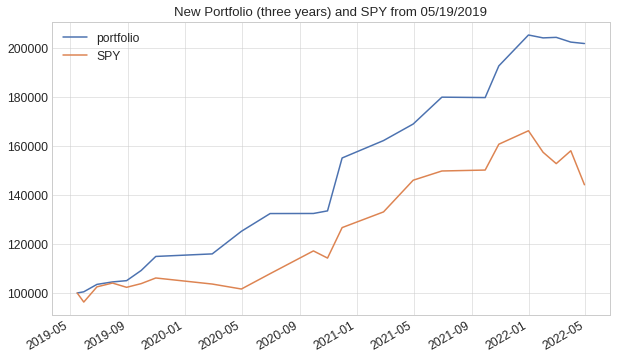

In [47]:
plot_df.plot(grid=True, title=f'New Portfolio (three years) and SPY from {d3_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
Final portfolio values for the three year investment:
</p>

In [48]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))


asset_df = get_asset_investments(risk_asset=rotation_etf_shy,
                                 bond_asset=cash_trigger_bond_adjclose,
                                 spy_data=spy_data,
                                 start_date=d1_year_start,
                                 end_date=end_date
                                 )

new_portfolio_df = investment_return(holdings=holdings,
                                     investment_df=asset_df,
                                     prices_df=all_assets)

new_portfolio_adj_df, spy_period_adj = adjust_time_series(new_portfolio_df, spy_close)

plot_df = build_plot_data(holdings=holdings, portfolio_df=new_portfolio_adj_df, spy_df=spy_period_adj)

╒═════════════════════╤═════════════╤════════╕
│                     │   portfolio │    SPY │
╞═════════════════════╪═════════════╪════════╡
│ 2022-04-29 00:00:00 │      201733 │ 144137 │
╘═════════════════════╧═════════════╧════════╛


<h3>
Past Year
</h3>

<AxesSubplot:title={'center':'New Portfolio (one year) and SPY from 05/19/2021'}>

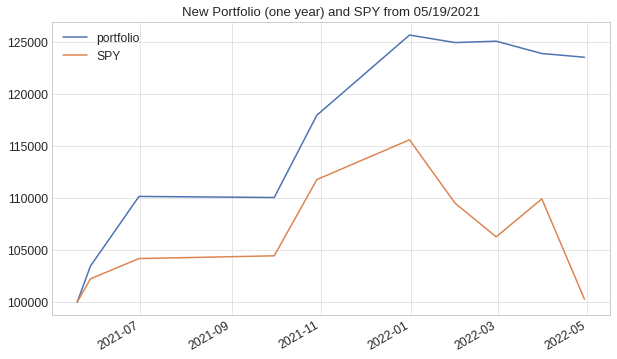

In [49]:
plot_df.plot(grid=True, title=f'New Portfolio (one year) and SPY from {d1_year_start.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
Final portfolio values for the one year investment:
</p>

In [50]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))

d2022_date_str = '2022-01-03'
d2022_start_date: datetime = datetime.fromisoformat(d2022_date_str)

asset_df = get_asset_investments(risk_asset=rotation_etf_shy,
                                 bond_asset=cash_trigger_bond_adjclose,
                                 spy_data=spy_data,
                                 start_date=d2022_start_date,
                                 end_date=end_date
                                 )

new_portfolio_df = investment_return(holdings=holdings,
                                     investment_df=asset_df,
                                     prices_df=all_assets)

new_portfolio_adj_df, spy_period_adj = adjust_time_series(new_portfolio_df, spy_close)

plot_df = build_plot_data(holdings=holdings, portfolio_df=new_portfolio_adj_df, spy_df=spy_period_adj)

╒═════════════════════╤═════════════╤════════╕
│                     │   portfolio │    SPY │
╞═════════════════════╪═════════════╪════════╡
│ 2022-04-29 00:00:00 │      123535 │ 100277 │
╘═════════════════════╧═════════════╧════════╛


<h3>
Portfolio in 2022
</h3>
<p>
This section shows the portfolio performance for an investment made on the first
trading day of 2022.
</p>

<AxesSubplot:title={'center':'New Portfolio (2022) and SPY from 01/03/2022'}>

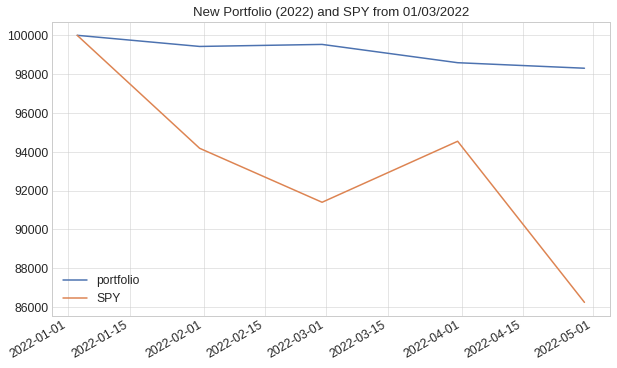

In [51]:
plot_df.plot(grid=True, title=f'New Portfolio (2022) and SPY from {d2022_start_date.strftime("%m/%d/%Y")}', figsize=(10,6))

<p>
Final portfolio values for the 2022 investment is:
</p>

In [52]:
terminal_vals_s = plot_df[:].iloc[-1]
terminal_vals_df = pd.DataFrame(terminal_vals_s).transpose()
print(tabulate(terminal_vals_df, headers=[*terminal_vals_df.columns], tablefmt='fancy_grid', floatfmt=".0f"))

╒═════════════════════╤═════════════╤═══════╕
│                     │   portfolio │   SPY │
╞═════════════════════╪═════════════╪═══════╡
│ 2022-04-29 00:00:00 │       98305 │ 86245 │
╘═════════════════════╧═════════════╧═══════╛


<p>
The assets that were purchased by the strategy for 2022 (to date) are:
</p>

In [53]:
print(tabulate(asset_df, headers=[*asset_df.columns], tablefmt='fancy_grid'))


╒═════════════════════╤═════════╤═════════════════════╤═════════════════════╤═══════════╕
│                     │ asset   │ start_date          │ end_date            │ risk-on   │
╞═════════════════════╪═════════╪═════════════════════╪═════════════════════╪═══════════╡
│ 2022-01-03 00:00:00 │ SHY     │ 2022-01-03 00:00:00 │ 2022-01-31 00:00:00 │ True      │
├─────────────────────┼─────────┼─────────────────────┼─────────────────────┼───────────┤
│ 2022-02-01 00:00:00 │ MDY     │ 2022-02-01 00:00:00 │ 2022-02-28 00:00:00 │ True      │
├─────────────────────┼─────────┼─────────────────────┼─────────────────────┼───────────┤
│ 2022-03-01 00:00:00 │ JNK     │ 2022-03-01 00:00:00 │ 2022-03-31 00:00:00 │ False     │
├─────────────────────┼─────────┼─────────────────────┼─────────────────────┼───────────┤
│ 2022-04-01 00:00:00 │ SHY     │ 2022-04-01 00:00:00 │ 2022-04-29 00:00:00 │ True      │
╘═════════════════════╧═════════╧═════════════════════╧═════════════════════╧═══════════╛


<h3>
ETF Rotation/Cash Trigger Portfolio: Discussion
</h3>
<p>
The future is unknown. The only way we can evaluate an investment strategy is by looking
at how it would have performed in the past. This strategy works well when the future
is similar to the past.
</p>
<p>
From 2008 to 2021 western governments have pumped money into their economies (through
the so-called "quantitative easing") to avoid
serious recessions caused by either the 2008-2009 "Great Recession" or the 2020 COVID-19
market crash.
</p>
<p>
This changed around 2020. With global supply chains under pressure from COVID-19 disruptions
and Russia's unprovoked invasion of Ukraine on February 24, 2022 causing a large increase
in energy prices. Inflation rose to levels that had not been seen in decades. The western central
banks backed away from monetary expansion and started raising interest rates. The stock
market and the economy entered a new regime. This regime appears to be different from
the historial period from 2008 to 2020.
</p>
<p>
The 2020-2021 COVID-19 period reminded the observer that the
stock market is not the economy, so it is difficult to fully understand how the new
regime will unfold.
</p>
<p>
For the year to date in 2022, the ETF rotation/cash trigger strategy performed better
than SPY, but is still slightly negtative (as of May 2022). An investment in dividend stocks
(see <a href="https://github.com/IanLKaplan/all_weather_portfolio/blob/master/dividend_portfolio.ipynb">
Dividend Portfolios</a>) or dividend ETFs (Schwab's SCHP, for example) would have performed
better in 2022.
</p>

<h2>
Disclaimer
</h2>
<p>
This notebook is not financial advice, investment advice, or tax advice.
The information in this notebook is for informational and recreational purposes only.
Investment products discussed (ETFs, mutual funds, etc.) are for illustrative purposes
only. This is not a recommendation to buy, sell, or otherwise transact in any of the
products mentioned. Do your own due diligence. Past performance does not guarantee
future returns.
</p>